In [ ]:
##!pip install --upgrade --no-cache-dir gdown
##!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
# use the other file ids if the first one doesn't work
#!gdown  --id 1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU
#!gdown --id 1RwjzPz-MJ5m2bhStVIDUS9l9jfwQ-sSW
##!unzip -q landscapes.zip -d ./data_colorization

/home/tico/anaconda3/envs/DDPG_env/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
From (redirected): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0&confirm=t&uuid=cab74c7f-5353-43de-bcc7-f48ada0099f4
To: /home/tico/Desktop/master_research/fabian_research/stable_diffusion_cr/sd/landscapes.zip
100%|████████████████████████████████████████| 650M/650M [00:07<00:00, 85.4MB/s]


In [2]:
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import numpy as np

class PineappleDataset(Dataset):
    def __init__(self, train=True, train_ratio=0.8):
        # Get all images sorted from the specified folder.
        self.all_images = sorted(glob.glob("./FULL_VERTICAL_PINEAPPLE/FULL_UNIFIED/*"))
        # Calculate the index at which to split the dataset.
        split_index = int(len(self.all_images) * train_ratio)
        # Partition the images based on the 'train' flag.
        if train:
            self.images = self.all_images[:split_index]
        else:
            self.images = self.all_images[split_index:]
        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        channels = 3
        # Resize the image.
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        # Convert to float32 and normalize.
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        # Rearrange the dimensions to (channels, height, width).
        image = np.transpose(image, (2, 0, 1))
        return image

    def __getitem__(self, idx):
        image = self.transform_image(self.images[idx])
        sample = {'image': image, 'idx': idx}
        return sample

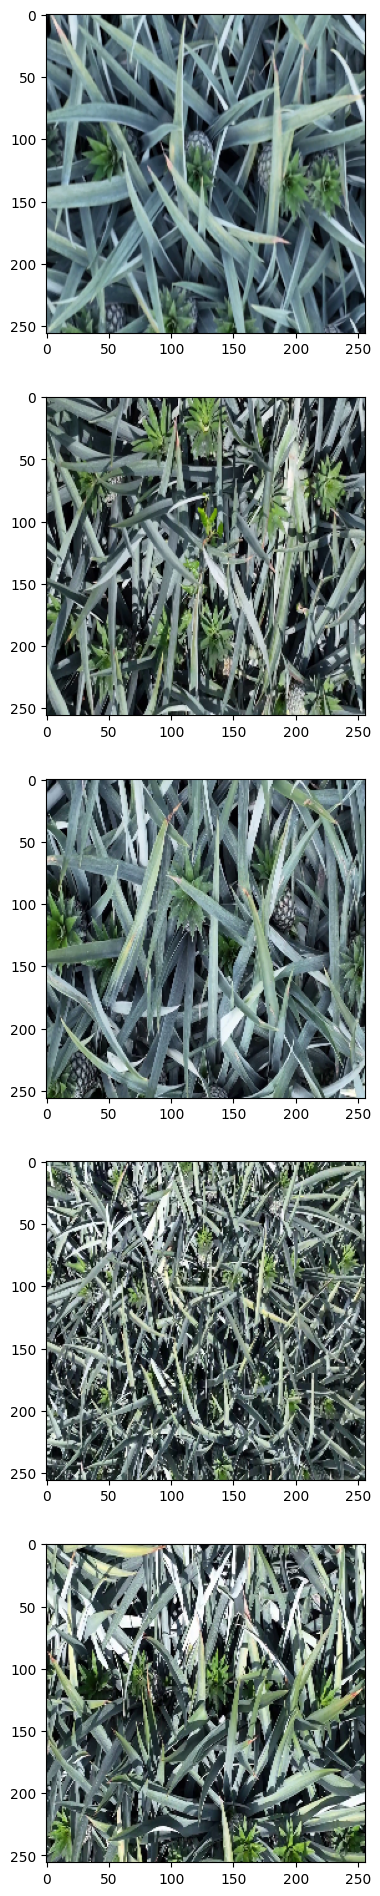

In [3]:
import matplotlib.pyplot as plt
trainset = PineappleDataset(train=True, train_ratio=0.8)
fig=plt.figure(figsize=(24, 24))
columns = 1
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
plt.show()

/tmp/ipykernel_323002/1472632074.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


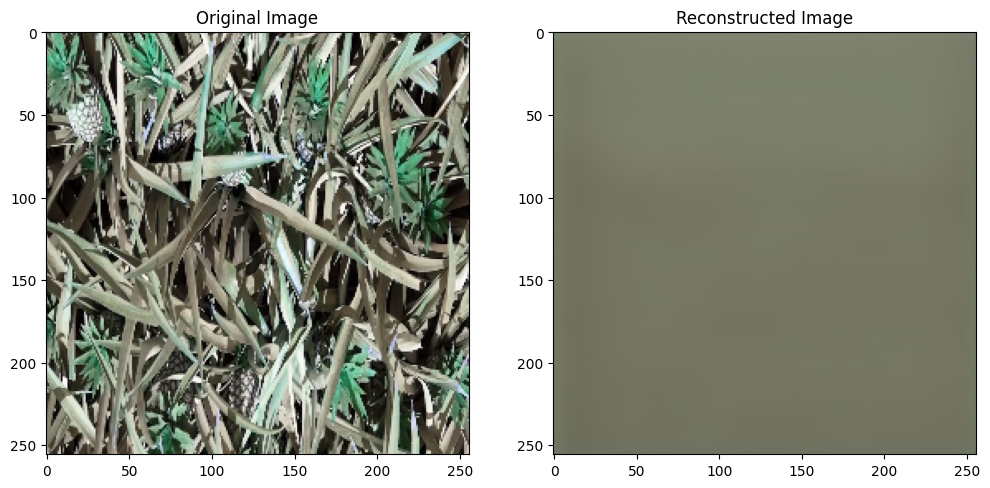

In [5]:
import torch
import numpy as np
import cv2
from VAE import VAE  # Make sure VAE is correctly imported from your VAE.py

# 1. Load the trained VAE checkpoint
model = VAE()
checkpoint_path = "weights_ck_3.pt"  # Replace with your checkpoint file
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval()
model.cuda()  # Move model to GPU if available

test_set = PineappleDataset(train=False, train_ratio=0.8)
# 2. Load the test image
test_image = test_set[0]['image']
test_image = torch.tensor(test_image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU
# 3. Pass the image through the model
with torch.no_grad():
    reconstructed_image, _, _ = model(test_image)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
    reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  # Change to HWC format
    reconstructed_image = (reconstructed_image * 255).astype(np.uint8)  # Convert to uint8
# 4. Display the original and reconstructed images
fig = plt.figure(figsize=(12, 6))
columns = 2
rows = 1
original_image = test_set[0]['image'].transpose((1, 2, 0))
original_image = (original_image * 255).astype(np.uint8)  # Convert to uint8
# add labels to the images
fig.add_subplot(rows, columns, 1, title='Original Image')
plt.imshow(original_image)
fig.add_subplot(rows, columns, 2, title='Reconstructed Image')
plt.imshow(reconstructed_image)
plt.show()
